In [85]:
import numpy as np
import warnings
from hdf5storage import loadmat,savemat
from matplotlib import pyplot as plt
from scipy.stats import sem

In [13]:
def convergence_test(fval, previous_fval, threshold=1e-4, warn=False):
    """
    Check if an objective function has converged.

    We have converged if the slope of the function falls below 'threshold',
    i.e., |f(t) - f(t-1)| / avg < threshold,
    where avg = (|f(t)| + |f(t-1)|)/2.
    'threshold' defaults to 1e-4.
    This stopping criterion is from Numerical Recipes in C p423.
    """

    converged = False
    delta_fval = np.abs(fval - previous_fval)
    avg_fval = (np.abs(fval) + np.abs(previous_fval) + np.finfo(float).eps) / 2

    if delta_fval / avg_fval < threshold:
        converged = True

    if warn and (fval - previous_fval) < -2 * np.finfo(float).eps:  # fval < previous_fval
        warnings.warn('objective decreased!', UserWarning)

    return converged

In [14]:
def ggmFitHtf(S, G, maxIter=30):
    # MLE for a precision matrix given known zeros in the graph
    # S is d*d sample covariance matrix
    # G is d*d adjacency matrix
    # We use the algorithm due to 
    # Hastie, Tibshirani & Friedman ("Elements" book, 2nd Ed, 2008, p633)
    # This file is from pmtk3.googlecode.com
    p = S.shape[0] 
    W = S # W = inv(precMat)
    precMat = np.zeros((p, p))
    beta = np.zeros(p-1)
    iter = 1
    converged = False
    normW = np.linalg.norm(W)
    while not converged:
        for i in range(p):
            # partition W & S for i
            noti = np.concatenate((np.arange(i), np.arange(i+1, p)))
            W11 = W[noti,:][:,noti]
            w12 = W[noti,i]
            s22 = S[i,i]
            s12 = S[noti,i]

            # find G's non-zero index in W11
            idx = np.nonzero(G[noti,i])[0]  # non-zeros in G11
            beta[:] = 0
            beta[idx] = np.linalg.solve(W11[np.ix_(idx,idx)], s12[idx])

            # update W
            w12 = W11 @ beta
            W[noti,i] = w12 
            W[i,noti] = w12

            # update precMat (technically only needed on last iteration)
            p22 = max([0,  1/(s22 - w12 @ beta)])  # must be non-neg
            p12 = -beta * p22
            precMat[noti,i] = p12
            precMat[i,noti] = p12
            precMat[i,i] = p22

        converged = convergence_test(np.linalg.norm(W),normW) | (iter > maxIter)
        normW = np.linalg.norm(W)
        iter += 1

    # ensure symmetry 
    precMat = (precMat + precMat.T)/2
    
    return precMat, iter


re-estimate the 12 session x 2 subjects x 12 trial 

In [15]:
# General: a single model for all
data = loadmat('/home/zhibinz2/Documents/GitHub/1overf/Pcorr_single_model/pcorr_single.mat')
singlepcorr = data['pcorr']


In [16]:
# organize file in time sequence
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)
# file directory of the pcorr output for each session
filedir="/home/zhibinz2/Documents/GitHub/1overf/Pcorr_trial_level/" # your own data directory
pathname = 'pcorr/'
dir=filedir+pathname

In [24]:
re_parcor_all=np.zeros([12,12,2,30,32,32])
iter_all=np.zeros([12,12,2,30,32,32])

for ses in range(12):
	filename='clean_'+str(filedates[ses])+'_pcorr.mat'
	spectral=loadmat(dir+filename)
	ampcorr = spectral['empirical_amplitude_correlation']
	for trl in range(12):
		for subj in range(2):
			for freq in range(30):
				# single trial
				S = ampcorr[subj,trl,freq,:,:]
				# general model
				x = singlepcorr[freq,:,:]
				G = x.astype('bool')
				G = G.astype('int')
				# re-estimate
				precMat,iter = ggmFitHtf(S, G, maxIter=100)
				y = np.diag(precMat)
				yy = np.outer(y,y)
				yy = np.sqrt(yy)
				parcor = precMat/yy 
				re_parcor_all[ses,trl,subj,freq,:,:]=parcor
				iter_all[ses,trl,subj,freq,:,:]=iter

# takes 1 min	
								

In [25]:
# save
outdict=dict()
outdict['re_parcor_all']=re_parcor_all
outdict['iter_all']=iter_all
savemat('re_estimate',outdict,store_python_metadata=True)

organize into 2 syn types 4 conditions

In [19]:
# # load 
# outdict=loadmat('re_estimate.mat')
# re_parcor_all=outdict["re_parcor_all"]
# iter_all=outdict["iter_all"]

In [26]:
# load condition_all
outdict=loadmat('/home/zhibinz2/Documents/GitHub/1overf/Pcorr_trial_level/conditions_all.mat')
conditions_all=outdict["conditions_all"]

# Organize indicies 
Uncoupled_Ind=np.zeros((12,3))
L_Lead_Ind=np.zeros((12,3)) # they were leading indicies for L subject but following for R
R_Lead_Ind=np.zeros((12,3))
Mutual_Ind=np.zeros((12,3))

for ses in range(12):
    Uncoupled_Ind[ses]=np.asarray(np.where(conditions_all[ses]==1))
    L_Lead_Ind[ses]=np.asarray(np.where(conditions_all[ses]==2))
    R_Lead_Ind[ses]=np.asarray(np.where(conditions_all[ses]==3))
    Mutual_Ind[ses]=np.asarray(np.where(conditions_all[ses]==4))

In [76]:
#  re_parcor_all into 4 conditions in 2 syn types
# append all trials of the same condition together
synch_Uncoupled = [[] for i in range(30)]
synch_Leading   = [[] for i in range(30)]
synch_Following = [[] for i in range(30)]
synch_Mutual    = [[] for i in range(30)]

synco_Uncoupled = [[] for i in range(30)]
synco_Leading   = [[] for i in range(30)]
synco_Following = [[] for i in range(30)]
synco_Mutual    = [[] for i in range(30)]


for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    synch_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synch_Leading[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Following[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])
                else:
                    synch_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synch_Leading[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Following[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synch_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])

for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    synco_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synco_Leading[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Following[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])
                else:
                    synco_Uncoupled[freq].append(re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:])
                    synco_Leading[freq].append(re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Following[freq].append(re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:])
                    synco_Mutual[freq].append(re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:])

# appended 36 trials in each frequencies for each conditions

In [35]:
# # sum the re_parcor matricies in each frequency
# sum_synch_Uncoupled = np.zeros((30,32,32))
# sum_synch_Leading   = np.zeros((30,32,32))
# sum_synch_Following = np.zeros((30,32,32))
# sum_synch_Mutual    = np.zeros((30,32,32))

# sum_synco_Uncoupled = np.zeros((30,32,32))
# sum_synco_Leading   = np.zeros((30,32,32))
# sum_synco_Following = np.zeros((30,32,32))
# sum_synco_Mutual    = np.zeros((30,32,32))

# for freq in range(30):
#     sum_synch_Uncoupled[freq] = sum(synch_Uncoupled[freq])
#     sum_synch_Leading[freq]   = sum(synch_Leading[freq])
#     sum_synch_Following[freq] = sum(synch_Following[freq])
#     sum_synch_Mutual[freq]    = sum(synch_Mutual[freq])

#     sum_synco_Uncoupled[freq] = sum(synco_Uncoupled[freq])
#     sum_synco_Leading[freq]   = sum(synco_Leading[freq])
#     sum_synco_Following[freq] = sum(synco_Following[freq])
#     sum_synco_Mutual[freq]    = sum(synco_Mutual[freq])

In [38]:
# # averaging the sum of the re_parcor matricies in each frequency by 36 trial
# mean_synch_Uncoupled = np.zeros((30,32,32))
# mean_synch_Leading   = np.zeros((30,32,32))
# mean_synch_Following = np.zeros((30,32,32))
# mean_synch_Mutual    = np.zeros((30,32,32))

# mean_synco_Uncoupled = np.zeros((30,32,32))
# mean_synco_Leading   = np.zeros((30,32,32))
# mean_synco_Following = np.zeros((30,32,32))
# mean_synco_Mutual    = np.zeros((30,32,32))

# for freq in range(30):
#     mean_synch_Uncoupled [freq]= sum_synch_Uncoupled[freq] /36
#     mean_synch_Leading   [freq]= sum_synch_Leading[freq]   /36
#     mean_synch_Following [freq]= sum_synch_Following[freq] /36
#     mean_synch_Mutual    [freq]= sum_synch_Mutual[freq]    /36

#     mean_synco_Uncoupled [freq]= sum_synco_Uncoupled[freq] /36
#     mean_synco_Leading   [freq]= sum_synco_Leading[freq]   /36
#     mean_synco_Following [freq]= sum_synco_Following[freq] /36
#     mean_synco_Mutual    [freq]= sum_synco_Mutual[freq]    /36

In [77]:
# mean of the re_parcor matricies in each frequency
mean_synch_Uncoupled = np.zeros((30,32,32))
mean_synch_Leading   = np.zeros((30,32,32))
mean_synch_Following = np.zeros((30,32,32))
mean_synch_Mutual    = np.zeros((30,32,32))

mean_synco_Uncoupled = np.zeros((30,32,32))
mean_synco_Leading   = np.zeros((30,32,32))
mean_synco_Following = np.zeros((30,32,32))
mean_synco_Mutual    = np.zeros((30,32,32))

for freq in range(30):
    mean_synch_Uncoupled[freq] = (np.asarray(synch_Uncoupled[freq])).mean(0)
    mean_synch_Leading[freq]   = (np.asarray(synch_Leading  [freq])).mean(0)
    mean_synch_Following[freq] = (np.asarray(synch_Following[freq])).mean(0)
    mean_synch_Mutual[freq]    = (np.asarray(synch_Mutual   [freq])).mean(0)

    mean_synco_Uncoupled[freq] = (np.asarray(synco_Uncoupled[freq])).mean(0)
    mean_synco_Leading[freq]   = (np.asarray(synco_Leading  [freq])).mean(0)
    mean_synco_Following[freq] = (np.asarray(synco_Following[freq])).mean(0)
    mean_synco_Mutual[freq]    = (np.asarray(synco_Mutual   [freq])).mean(0)

In [103]:
# sem of the re_parcor matricies in each frequency
sem_synch_Uncoupled = np.zeros((30,32,32))
sem_synch_Leading   = np.zeros((30,32,32))
sem_synch_Following = np.zeros((30,32,32))
sem_synch_Mutual    = np.zeros((30,32,32))

sem_synco_Uncoupled = np.zeros((30,32,32))
sem_synco_Leading   = np.zeros((30,32,32))
sem_synco_Following = np.zeros((30,32,32))
sem_synco_Mutual    = np.zeros((30,32,32))

for freq in range(30):
    sem_synch_Uncoupled[freq] = sem(np.asarray(synch_Uncoupled[freq]))
    sem_synch_Leading[freq]   = sem(np.asarray(synch_Leading  [freq]))
    sem_synch_Following[freq] = sem(np.asarray(synch_Following[freq]))
    sem_synch_Mutual[freq]    = sem(np.asarray(synch_Mutual   [freq]))

    sem_synco_Uncoupled[freq] = sem(np.asarray(synco_Uncoupled[freq]))
    sem_synco_Leading[freq]   = sem(np.asarray(synco_Leading  [freq]))
    sem_synco_Following[freq] = sem(np.asarray(synco_Following[freq]))
    sem_synco_Mutual[freq]    = sem(np.asarray(synco_Mutual   [freq]))

In [104]:
mean_synch_4condi=[mean_synch_Uncoupled, mean_synch_Leading, mean_synch_Following, mean_synch_Mutual]
mean_synco_4condi=[mean_synco_Uncoupled, mean_synco_Leading, mean_synco_Following, mean_synco_Mutual]

sem_synch_4condi=[sem_synch_Uncoupled, sem_synch_Leading, sem_synch_Following, sem_synch_Mutual]
sem_synco_4condi=[sem_synco_Uncoupled, sem_synco_Leading, sem_synco_Following, sem_synco_Mutual]

In [81]:
# compute number of edges in each trial
#  re_parcor_all into 4 conditions in 2 syn types
# append all trials of the same condition together
numedge_synch_Uncoupled = [[] for i in range(30)]
numedge_synch_Leading   = [[] for i in range(30)]
numedge_synch_Following = [[] for i in range(30)]
numedge_synch_Mutual    = [[] for i in range(30)]

numedge_synco_Uncoupled = [[] for i in range(30)]
numedge_synco_Leading   = [[] for i in range(30)]
numedge_synco_Following = [[] for i in range(30)]
numedge_synco_Mutual    = [[] for i in range(30)]


for ses in list(range(0,12,2)): # synch [0, 2, 4, 6, 8, 10]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    numedge_synch_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synch_Leading   [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synch_Following [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synch_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                else:
                    numedge_synch_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synch_Leading   [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synch_Following [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synch_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)

for ses in list(range(1,12,2)): # [1, 3, 5, 7, 9, 11]
    for subj in range(2):
        for trl in range(3):
            for freq in range(30):
                if subj == 0:
                    numedge_synco_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synco_Leading   [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synco_Following [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synco_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                else:
                    numedge_synco_Uncoupled [freq].append((np.sum((re_parcor_all[ses,int(Uncoupled_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synco_Leading   [freq].append((np.sum((re_parcor_all[ses,int(R_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synco_Following [freq].append((np.sum((re_parcor_all[ses,int(L_Lead_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)
                    numedge_synco_Mutual    [freq].append((np.sum((re_parcor_all[ses,int(Mutual_Ind[ses][trl]),subj,freq,:,:]).astype('bool'))-32)/2)

In [82]:
# mean of the number of edges in each frequency
numedge_mean_synch_Uncoupled = np.zeros((30))
numedge_mean_synch_Leading   = np.zeros((30))
numedge_mean_synch_Following = np.zeros((30))
numedge_mean_synch_Mutual    = np.zeros((30))

numedge_mean_synco_Uncoupled = np.zeros((30))
numedge_mean_synco_Leading   = np.zeros((30))
numedge_mean_synco_Following = np.zeros((30))
numedge_mean_synco_Mutual    = np.zeros((30))

for freq in range(30):
    numedge_mean_synch_Uncoupled[freq] = (np.asarray(numedge_synch_Uncoupled[freq])).mean(0)
    numedge_mean_synch_Leading[freq]   = (np.asarray(numedge_synch_Leading  [freq])).mean(0)
    numedge_mean_synch_Following[freq] = (np.asarray(numedge_synch_Following[freq])).mean(0)
    numedge_mean_synch_Mutual[freq]    = (np.asarray(numedge_synch_Mutual   [freq])).mean(0)

    numedge_mean_synco_Uncoupled[freq] = (np.asarray(numedge_synco_Uncoupled[freq])).mean(0)
    numedge_mean_synco_Leading[freq]   = (np.asarray(numedge_synco_Leading  [freq])).mean(0)
    numedge_mean_synco_Following[freq] = (np.asarray(numedge_synco_Following[freq])).mean(0)
    numedge_mean_synco_Mutual[freq]    = (np.asarray(numedge_synco_Mutual   [freq])).mean(0)

In [118]:
print(numedge_mean_synco_Leading)

[357. 344. 332. 319. 323. 339. 321. 324. 307. 288. 296. 320. 351. 372.
 378. 390. 378. 396. 388. 386. 392. 399. 402. 415. 405. 415. 412. 416.
 417. 423.]


In [105]:
# sem of the number of edges in each frequency
numedge_sem_synch_Uncoupled = np.zeros((30))
numedge_sem_synch_Leading   = np.zeros((30))
numedge_sem_synch_Following = np.zeros((30))
numedge_sem_synch_Mutual    = np.zeros((30))

numedge_sem_synco_Uncoupled = np.zeros((30))
numedge_sem_synco_Leading   = np.zeros((30))
numedge_sem_synco_Following = np.zeros((30))
numedge_sem_synco_Mutual    = np.zeros((30))

for freq in range(30):
    numedge_sem_synch_Uncoupled[freq] = sem(np.asarray(numedge_synch_Uncoupled[freq]))
    numedge_sem_synch_Leading[freq]   = sem(np.asarray(numedge_synch_Leading  [freq]))
    numedge_sem_synch_Following[freq] = sem(np.asarray(numedge_synch_Following[freq]))
    numedge_sem_synch_Mutual[freq]    = sem(np.asarray(numedge_synch_Mutual   [freq]))

    numedge_sem_synco_Uncoupled[freq] = sem(np.asarray(numedge_synco_Uncoupled[freq]))
    numedge_sem_synco_Leading[freq]   = sem(np.asarray(numedge_synco_Leading  [freq]))
    numedge_sem_synco_Following[freq] = sem(np.asarray(numedge_synco_Following[freq]))
    numedge_sem_synco_Mutual[freq]    = sem(np.asarray(numedge_synco_Mutual   [freq]))

In [106]:
numedge_mean_synch_4condi=[numedge_mean_synch_Uncoupled, numedge_mean_synch_Leading, 
                            numedge_mean_synch_Following, numedge_mean_synch_Mutual]
numedge_mean_synco_4condi=[numedge_mean_synco_Uncoupled, numedge_mean_synco_Leading, 
                            numedge_mean_synco_Following, numedge_mean_synco_Mutual]


numedge_sem_synch_4condi=[numedge_sem_synch_Uncoupled,  numedge_sem_synch_Leading,
                             numedge_sem_synch_Following, numedge_sem_synch_Mutual]
numedge_sem_synco_4condi=[numedge_sem_synco_Uncoupled,  numedge_sem_synco_Leading,
                             numedge_sem_synco_Following, numedge_sem_synco_Mutual]

ploting

In [ ]:
# visualization of parcor selection in synch
states4names=['Uncoupled','Leading','Following','Mutual']
color_4st=['green','red','blue','black']
figure,axs = plt.subplots(30,4,constrained_layout=True)
for condi in range(4):
		plt.sca(axs[freq,condi])
		plt.plot (np.arange(30)+1,numedge_mean_synch_4condi[condi],color=color_4st[condi])
		plt.fill_between(np.arange(30)+1,numedge_mean_synch_4condi[condi]-numedge_sem_synch_4condi[condi],\
		   numedge_mean_synch_4condi[condi]+numedge_sem_synch_4condi[condi],\
			color=color_4st[condi], alpha=.1)
		plt.xlabel("frequency (Hz)")
		plt.ylabel("pcorr")




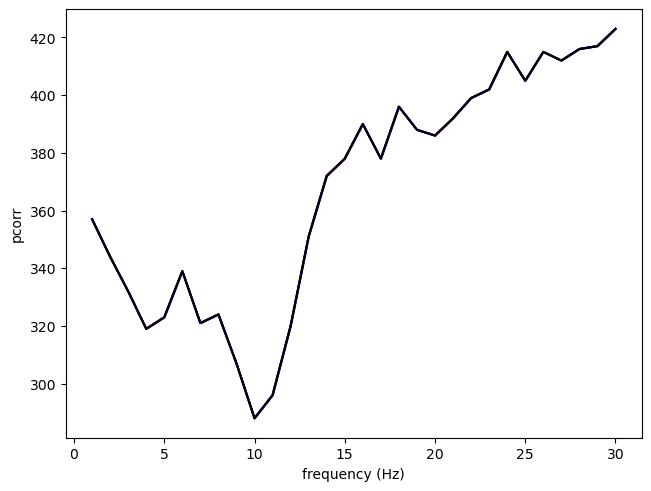

In [112]:
figure,axs = plt.subplots(1,1,constrained_layout=True)
for condi in range(4):
		plt.plot (np.arange(30)+1,numedge_mean_synch_4condi[condi],color=color_4st[condi])
		plt.fill_between(np.arange(30)+1,numedge_mean_synch_4condi[condi]-numedge_sem_synch_4condi[condi],\
		   numedge_mean_synch_4condi[condi]+numedge_sem_synch_4condi[condi],\
			color=color_4st[condi], alpha=.1)
		plt.xlabel("frequency (Hz)")
		plt.ylabel("pcorr")